First load in the required external libraries for python

In [2]:
import numpy as np
import netCDF4 as nc
import matplotlib.pylab as plt
import cmocean 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import urllib.request as urllib2
import requests
import xarray as xr
from scipy import stats

Now load in some example data file. For our purposes here we are using the ClimateNet dataset described here https://gmd.copernicus.org/articles/14/107/2021/ which itself takes snapshots from the Community Atmospheric Model (CAM5.1) output: https://www.cesm.ucar.edu/models/cesm1.0/cam/docs/description/cam5_desc.pdf. Don't worry too much about the specifics of the data, we are more interested in exploring here. 

First we construct a python string containing the location of the file then load this as an 'xarray' (a nice way of viewing and handling the tabulated data).

In [3]:
fn = 'test'+'.nc'
ds = xr.open_dataset(fn)

View the tabulated data (note this is interactive in a jupter notebook). Note the output cell below is interactive: try for yourself!

In [4]:
ds

<xarray.Dataset>
Dimensions:  (lat: 768, lon: 1152, time: 61)
Coordinates:
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * time     (time) object 'data-2011-06-01-01-1.nc' ... 'data-2013-09-27-01-...
Data variables: (12/17)
    TMQ      (time, lat, lon) float32 ...
    U850     (time, lat, lon) float32 ...
    V850     (time, lat, lon) float32 ...
    UBOT     (time, lat, lon) float32 ...
    VBOT     (time, lat, lon) float32 ...
    QREFHT   (time, lat, lon) float32 ...
    ...       ...
    TS       (time, lat, lon) float32 ...
    TREFHT   (time, lat, lon) float32 ...
    Z1000    (time, lat, lon) float32 ...
    Z200     (time, lat, lon) float32 ...
    ZBOT     (time, lat, lon) float32 ...
    LABELS   (time, lat, lon) int64 ...

The dataset is horizontally gridded with dimensions 768 x 1152. Let us load the latitude and longitude coordinates of each grid cell into memory. We can select coordinates from an xarray by using the dataset.coordinate notation, then convert the resulting dataset to a regular printable array using .values. 

In [5]:
#Load in the values of the latitude and longitude from the dataset, and print the array of longitude values (which unsurprisingly go from 0 to 360)
lon = ds.lon.values
lat = ds.lat.values 
print(lon) 

[0.000000e+00 3.125000e-01 6.250000e-01 ... 3.590625e+02 3.593750e+02
 3.596875e+02]


In exactly the same way, we can load in specific data variables. Remember you can check out what these are using the interactive xarray cell above. Note that this results in an array with an extra dimension, which corresponds to snapshots at different times (here we have 61 different times). We will worry about these in a moment. 

In [6]:
#Load in e.g. zonal winds at 850mb pressure surface. We can see that this is an array with three dimensions. 
#The first dimension is time.
#The second two dimensions are latitude and longitude.
U850 = ds.U850.values
print(U850.shape)

(61, 768, 1152)


Let us just select one time snapshot: the first one, for convenience. We can select along the first dimension using square brackets as follows:

In [7]:
#Select the first column of the first dimension using square brackets (python starts indexing at 0) and print values from the 2D array.
#These are the values of U850 at each latitude and longitude
print(U850[0])

[[-3.701085  -3.6890082 -3.6768215 ... -3.736654  -3.7249084 -3.713052 ]
 [-4.385527  -4.3593483 -4.3328357 ... -4.462033  -4.436871  -4.4113684]
 [-6.861711  -6.8401723 -6.818181  ... -6.9236383 -6.9034414 -6.8827996]
 ...
 [ 5.684656   5.6944284  5.7040105 ...  5.6542     5.664543   5.6746945]
 [ 5.929916   5.9488187  5.96755   ...  5.8721867  5.8916     5.910843 ]
 [ 5.8953314  5.922173   5.948838  ...  5.813758   5.841123   5.8683147]]


We want to visualize the data in some useful way. Since we have values of different climate variables at each latitude and longitude, it makes sense to do a contour plot. We can do special contour plots for data in latitude-longitude format using the module cartopy loaded above. This is set up as follows:

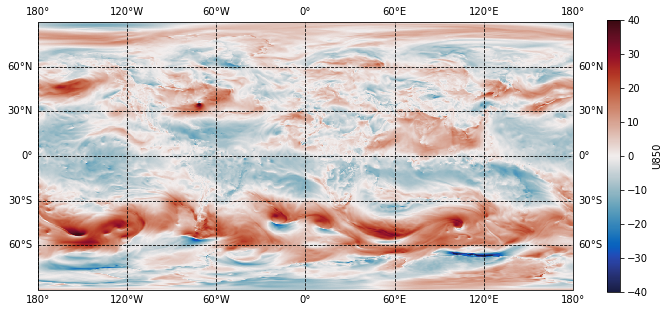

In [8]:
projection=ccrs.PlateCarree();
figsize = (12,5)
# Some other projections we might try (try uncommenting these!)
# projection=ccrs.Robinson();
# projection=ccrs.LambertCylindrical();

#for future reference, define a function to set up our map
def map_setup(figsize,projection):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(projection=projection)
    ax.add_feature(cfeature.LAND, facecolor='k')
    ax.gridlines(draw_labels=True, color='k', linestyle='--')  
    return fig, ax

fig, ax = map_setup(figsize,projection) 
image = ax.pcolormesh(lon, lat,U850[0], transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance, vmin=-40,vmax=40) 
#The cmocean module has very nice colour maps. They are listed here: https://matplotlib.org/cmocean/
fig.colorbar(image, ax=ax, label='U850')

We can see the characteristic strong westerly winds over the Southern ocean in the above plot. Now try loading in some other variables from the dataset and plotting those. 

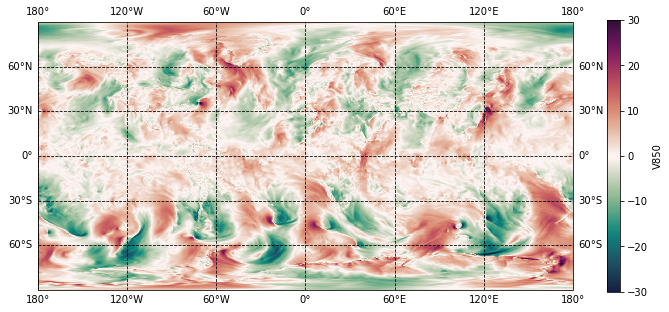

In [9]:
projection=ccrs.PlateCarree();
figsize = (12,5)

V850 = ds.V850.values
#Try replacing V850 with another data variable! Note you might need to change the parameters vmin and vmax which control the maximum and minimum colour scale levels.

fig, ax = map_setup(figsize,projection) 
image = ax.pcolormesh(lon, lat,V850[0], transform=ccrs.PlateCarree(), cmap=cmocean.cm.curl, vmin=-30, vmax=30) #Note different colormap!
fig.colorbar(image, ax=ax, label='V850')

Each snapshot in this dataset has been labelled with extreme weather events (see the LABELS data variable above). We can plot them using the below: here orange corresponds to an atmospheric river and purple corresponds to a tropical cyclone. 

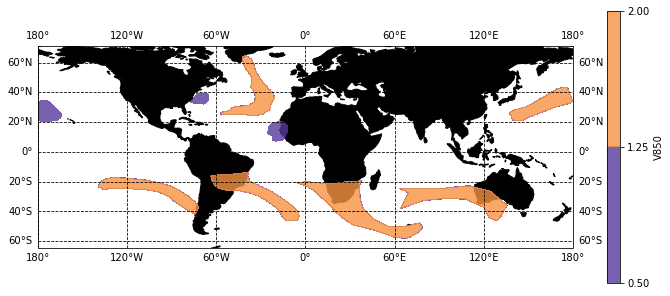

In [10]:
projection=ccrs.PlateCarree();
figsize = (12,5)

labels = ds.LABELS.values

fig, ax = map_setup(figsize,projection) 
image = ax.contourf(lon, lat,labels[0], transform=ccrs.PlateCarree(), levels=np.linspace(0.5,2,3), alpha=0.8, cmap=cmocean.cm.thermal) 
fig.colorbar(image, ax=ax, label='V850')

We can explore snapshots taken from different times. These are saved in a slightly unusual but fairly instructive format: data-YYYY-MM-DD-01-1.nc

In [11]:
time = ds.time.values
print(time) #A long array of all the different times from the models.

['data-2011-06-01-01-1.nc' 'data-2011-06-03-01-1.nc'
 'data-2011-06-03-01-1.nc' 'data-2011-06-16-01-1.nc'
 'data-2011-07-26-01-1.nc' 'data-2011-07-26-01-1.nc'
 'data-2011-07-29-01-1.nc' 'data-2011-08-08-01-1.nc'
 'data-2011-08-08-01-1.nc' 'data-2011-09-06-01-1.nc'
 'data-2011-09-06-01-1.nc' 'data-2011-09-09-01-1.nc'
 'data-2011-09-09-01-1.nc' 'data-2011-09-09-01-1.nc'
 'data-2011-09-09-01-1.nc' 'data-2011-09-12-01-1.nc'
 'data-2011-09-30-01-1.nc' 'data-2011-09-30-01-1.nc'
 'data-2011-09-30-01-1.nc' 'data-2011-09-30-01-1.nc'
 'data-2011-10-10-01-1.nc' 'data-2011-10-10-01-1.nc'
 'data-2011-10-30-01-1.nc' 'data-2012-06-18-01-1.nc'
 'data-2012-06-24-01-1.nc' 'data-2012-06-24-01-1.nc'
 'data-2012-06-24-01-1.nc' 'data-2012-06-24-01-1.nc'
 'data-2012-06-29-01-1.nc' 'data-2012-07-11-01-1.nc'
 'data-2012-07-11-01-1.nc' 'data-2012-07-11-01-1.nc'
 'data-2012-07-21-01-1.nc' 'data-2012-08-07-01-1.nc'
 'data-2012-08-07-01-1.nc' 'data-2012-08-07-01-1.nc'
 'data-2012-08-09-01-1.nc' 'data-2012-08-17-01

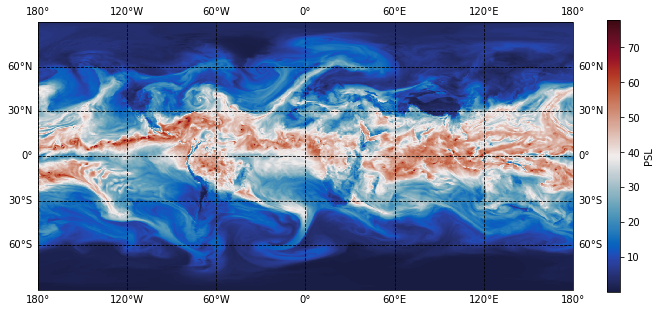

In [12]:
projection=ccrs.PlateCarree();
figsize = (12,5)
TMQ = ds.TMQ.values

fig, ax = map_setup(figsize,projection) 
image = ax.pcolormesh(lon, lat,TMQ[41], transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance) 
#The cmocean module has very nice colour maps. They are listed here: https://matplotlib.org/cmocean/
fig.colorbar(image, ax=ax, label='PSL')

Look at the location of extreme extreme weather events for this snapshot (potentially a wet day for Cambridge!): 

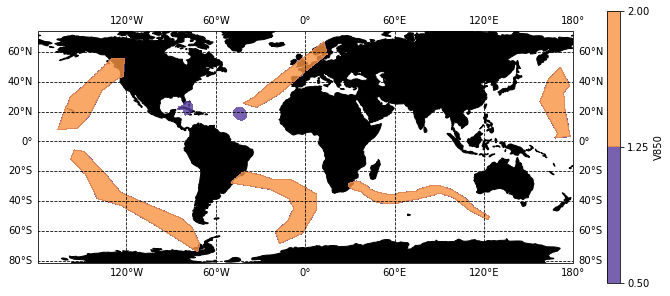

In [13]:
projection=ccrs.PlateCarree();
figsize = (12,5)

fig, ax = map_setup(figsize,projection) 
image = ax.contourf(lon, lat,labels[41], transform=ccrs.PlateCarree(), levels=np.linspace(0.5,2,3), alpha=0.8, cmap=cmocean.cm.thermal) 
fig.colorbar(image, ax=ax, label='V850')

For this example dataset we are going to try and explore which variables might be important for determining whether a given location is experiencing an extreme weather event. To make things more tractable let us first reduce the dimensions of our dataset. The simplest way to do this is to sparse, using the [::sparse_factor] notation.

Below we plot the total precipitable water with contours of extreme events on top, using a sparsed version of the snapshot we just looked at. Note the pattern that starts to emerge.

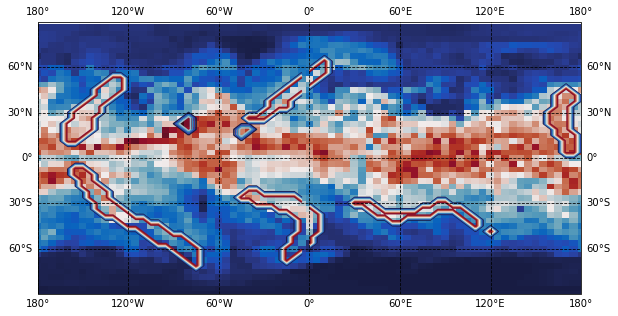

In [14]:
fig, ax = map_setup(figsize,projection) 
ax.pcolormesh(lon[::16], lat[::16],TMQ[41][::16,::16], transform=ccrs.PlateCarree(),cmap=cmocean.cm.balance) 
ax.contour(lon[::16], lat[::16],labels[41][::16,::16], transform=ccrs.PlateCarree(),cmap=cmocean.cm.balance) 

A slightly more sophisticated way to reduce dimensionality is to first perform a 2d moving average (essentially blurring the image) and then sparsing the resulting array. In this way each point represents an average value over an area surrounding that pixel. Formally, this is carried out by convolving the array with a Gaussian kernel, Luckily for us there is a function in scipy that does this automatically. Try playing around with the value of sigma (the variance of the convolution kernel) and see what happens below:

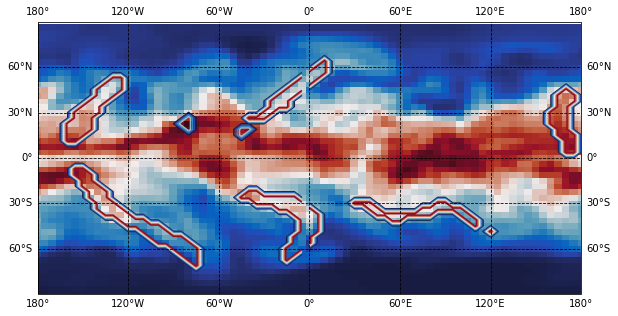

In [15]:
from scipy.ndimage.filters import gaussian_filter
fig, ax = map_setup(figsize,projection) 
filtered_TMQ = gaussian_filter(TMQ[41],sigma = 10)
plt.pcolormesh(lon[::16], lat[::16],filtered_TMQ[::16,::16],transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance) 
plt.contour(lon[::16], lat[::16],labels[41][::16,::16],transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance) 

From the above it looks like there is a link between the variable TMQ and atmospheric rivers. What other variables might be linked? Let's explore this further using a scatter plot. Try playing around with different variables and see if you notice any patterns. Remember to keep in mind here that we are really just exploring at the moment: the aim of all of this is to give us an idea about how we might best construct a model for predicting these extreme weather events. For example, which variables might be most useful for indicating the presence of an atmospheric river in a particular cell?

In [87]:
#Reprint the dataset here just for reference (so you don't have to scroll all the way back up!)
ds

<xarray.Dataset>
Dimensions:  (lat: 768, lon: 1152, time: 61)
Coordinates:
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * time     (time) object 'data-2011-06-01-01-1.nc' ... 'data-2013-09-27-01-...
Data variables: (12/17)
    TMQ      (time, lat, lon) float32 0.3222 0.3222 0.3222 ... 7.664 7.664 7.664
    U850     (time, lat, lon) float32 -3.701 -3.689 -3.677 ... -7.748 -7.759
    V850     (time, lat, lon) float32 -2.204 -2.224 -2.244 ... -2.051 -2.008
    UBOT     (time, lat, lon) float32 ...
    VBOT     (time, lat, lon) float32 ...
    QREFHT   (time, lat, lon) float32 ...
    ...       ...
    TS       (time, lat, lon) float32 ...
    TREFHT   (time, lat, lon) float32 ...
    Z1000    (time, lat, lon) float32 ...
    Z200     (time, lat, lon) float32 ...
    ZBOT     (time, lat, lon) float32 ...
    LABELS   (time, lat, lon) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0

Text(0, 0.5, 'log10(precipitation rate)')

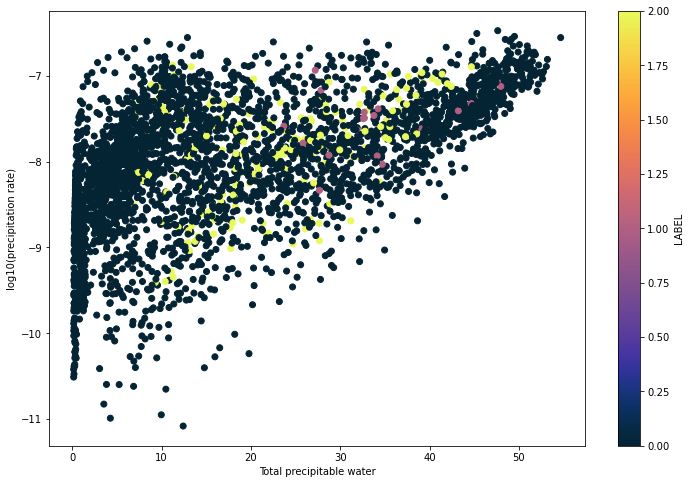

In [88]:
plt.figure(figsize=(12,8))
#Choose your variables here! Remember you can refer to the xarray and code for selecting a particular variable above.
#Note these variables have been sparsed with a Gaussian filter.

TMQ = ds.TMQ.values
PRECT = ds.PRECT.values
var1 = gaussian_filter(TMQ[41],sigma = 10)[::16,::16]
var2 = gaussian_filter(PRECT[41],sigma = 10)[::16,::16]

#Now do a scatter plot between these two variables, colouring the points by their label:
plt.scatter(var1.flatten(), np.log10(var2.flatten()), c=labels[0,::16,::16].flatten(), cmap=cmocean.cm.thermal)
plt.colorbar(label='LABEL')
plt.xlabel('Total precipitable water')
plt.ylabel('log10(precipitation rate)')

Scatter plots are quite nice for labelling tasks (such as determining an extreme weather event) since we can add an extra dimension by colouring the points. However for large datasets it can sometimes be difficult to spot patterns when very dense clusters of points exist. With too high a number of data points plotting each individual point eventually becomes intractable and so it makes sense to bin the data first and then plot it using a 2d histogram. This is particularly appropriate in our case, say, if we want to plot the trends over all snapshots.

Text(0, 0.5, 'log10(precipitation rate)')

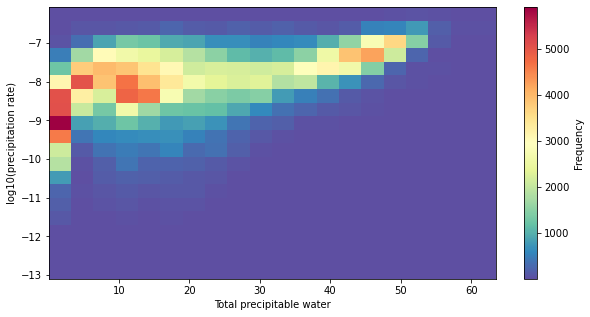

In [61]:
TMQ = ds.TMQ.values
PRECT = ds.PRECT.values

var1 = gaussian_filter(TMQ,sigma = [0,10,10])[::16,::16]
var2 = gaussian_filter(PRECT,sigma = [0,10,10])[::16,::16]
hist2d = np.histogram2d(np.log10(var2.flatten()), var1.flatten(), bins=20)
plt.figure(figsize=(10,5))
ax=plt.gca()
im = ax.pcolormesh(hist2d[2], hist2d[1], hist2d[0], vmin=1, cmap='Spectral_r')
plt.colorbar(im, label='Frequency')
plt.xlabel('Total precipitable water')
plt.ylabel('log10(precipitation rate)')

We can use our physical intuition to help us decode correlations. For example, you would probably imagine that the dynamics near the tropics are reasonably different to the dynamics at higher latitudes. We can filter our dataset accordingly using the xarray.where command. Note that this command is also useful for data cleaning purposes. You can play around with the filter below and see what correlations start to emerge more strongly.

In [89]:
filtered_ds = ds.where(abs(ds.lat) < 25, drop=True)
print(filtered_ds.lat)

<xarray.DataArray 'lat' (lat: 214)>
array([-24.993481, -24.758801, -24.52412 , ...,  24.52412 ,  24.758801,
        24.993481])
Coordinates:
  * lat      (lat) float64 -24.99 -24.76 -24.52 -24.29 ... 24.52 24.76 24.99


Now do exactly the same 2d histogram plot as above but for the filtered dataset. 

Text(0, 0.5, 'log10(precipitation rate)')

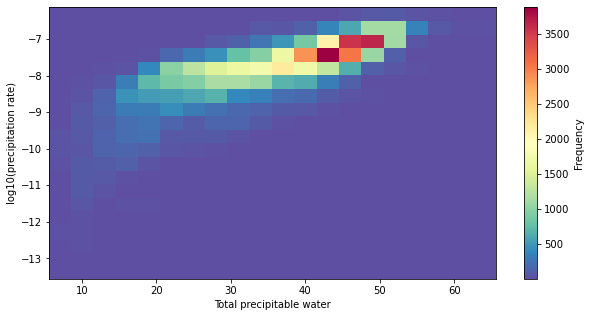

In [90]:
TMQ = filtered_ds.TMQ.values
PRECT = filtered_ds.PRECT.values

var1 = gaussian_filter(TMQ,sigma = [0,10,10])[::16,::16]
var2 = gaussian_filter(PRECT,sigma = [0,10,10])[::16,::16]
hist2d = np.histogram2d(np.log10(var2.flatten()), var1.flatten(), bins=20)
plt.figure(figsize=(10,5))
ax=plt.gca()
im = ax.pcolormesh(hist2d[2], hist2d[1], hist2d[0], vmin=1, cmap='Spectral_r')
plt.colorbar(im, label='Frequency')
plt.xlabel('Total precipitable water')
plt.ylabel('log10(precipitation rate)')

This serves as a very basic introduction to how you might start to build 'physics-informed' models. Though this is perhaps a mysterious term, very often the encoded physics is actually quite a simple conceptual idea that is captured in, for example, the inputs fed into the model. It is good to have some kind of idea about the sort of physics you expect your model to pick up on before designing it: this is likely to make the conclusions you draw from the model much more meaningful. 